<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Tools" data-toc-modified-id="Tools-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Tools</a></span></li><li><span><a href="#Select-your-motif" data-toc-modified-id="Select-your-motif-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Select your motif</a></span></li><li><span><a href="#Check-the-motif's-point-symmetry" data-toc-modified-id="Check-the-motif's-point-symmetry-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Check the motif's point symmetry</a></span></li><li><span><a href="#Select-the-global-pattern-symmetry" data-toc-modified-id="Select-the-global-pattern-symmetry-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Select the global pattern symmetry</a></span></li><li><span><a href="#Final-Steps" data-toc-modified-id="Final-Steps-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Final Steps</a></span></li></ul></div>

In [1]:
import json, os
import numpy as np
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

# Tools

In [2]:
library = '../motif_library/'
motif_coords = None
motif_types = None
motif_point_symmetry = None
induced = 'c1'

motif_selector = widgets.Dropdown(
    options=[f for f in os.listdir(library) if f.endswith('.json')],
    description='Motif',
    disabled=False,
    value=None
)

def on_motif_change(v):
    global motif_coords
    global motif_types
    global motif_symmetry
    info = json.load(open(library+v['new'], 'r'))
    motif_coords = info['coords'] 
    motif_types = info['types'] 
    motif_point_symmetry = info['symmetry'] 

motif_selector.observe(on_motif_change, names='value')

induced_selector = widgets.ToggleButtons(
    options=['Ignore (c1)', 'Use motif'],
    description=r'$S(\mathcal{P}|M):$',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Do not extend any of motif\'s symmetry to the tiling', 'Use some of motif\'s symmetry in tiling'],
#     icons=['check'] * 3
)

def on_induced_change(v):
    global induced
    if v['new'] == "Use motif":
        induced = motif_point_symmetry
    else:
        induced = 'c1'

induced_selector.observe(on_induced_change, names='value')

def plot(coords):
    coords = np.array(coords)
    plt.plot(coords[:,0], coords[:,1], 'o')
    plt.gca().axis('equal')

# Select your motif

In [3]:
display(motif_selector)

Dropdown(description='Motif', options=('d_1_vitruvian.json', 'c_1_random.json', 'd_inf_circle.json', 'd_6_hexa…

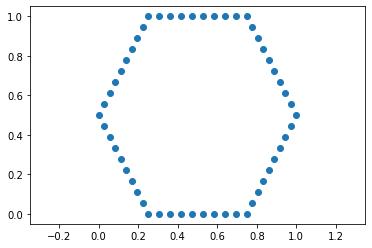

In [223]:
plot(motif_coords)

# Check the motif's point symmetry

You must have [pymatgen](https://pymatgen.org/index.html) installed for this to work, otherwise you can consider doing this manually and can skip ahead.

In [224]:
import pymatgen.symmetry.analyzer as psa
from pymatgen.core.structure import Molecule

In [225]:
mol = Molecule(
    species=["H"]*len(motif_coords),
    coords=np.hstack((np.array(motif_coords)*10, np.zeros((len(motif_coords),1)))),
    validate_proximity=True
)

In [226]:
a = psa.PointGroupAnalyzer(mol, tolerance=0.3, eigen_tolerance=0.01, matrix_tol=0.1)
a.get_pointgroup()

#d1 = C2v
#d2 = D2h

D2h

In [198]:
a.principal_axes

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.28761721e-15,  1.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [178]:
a.eigvals

array([0.47619048, 0.52380952, 1.        ])

In [179]:
inertia_tensor = np.zeros((3, 3))
total_inertia = 0
for site in a.centered_mol:
    c = site.coords
    wt = site.species.weight
    print(wt)
    for i in range(3):
        inertia_tensor[i, i] += wt * (c[(i + 1) % 3] ** 2 + c[(i + 2) % 3] ** 2)
    for i, j in [(0, 1), (1, 2), (0, 2)]:
        inertia_tensor[i, j] += -wt * c[i] * c[j]
        inertia_tensor[j, i] += -wt * c[j] * c[i]
    total_inertia += wt * np.dot(c, c)
inertia_tensor /= total_inertia

1.00794 amu
1.00794 amu
1.00794 amu
1.00794 amu
1.00794 amu
1.00794 amu
1.00794 amu
1.00794 amu
1.00794 amu
1.00794 amu
1.00794 amu
1.00794 amu
1.00794 amu
1.00794 amu


In [180]:
inertia_tensor

array([[ 4.76190476e-01, -6.71376637e-18,  0.00000000e+00],
       [-6.71376637e-18,  5.23809524e-01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [181]:
a.centered_mol

Molecule Summary
Site: H (-0.0000, 5.0000, 0.0000)
Site: H (-0.0000, 2.5000, 0.0000)
Site: H (-2.5000, 2.5000, 0.0000)
Site: H (-5.0000, 2.5000, 0.0000)
Site: H (-5.0000, -0.0000, 0.0000)
Site: H (2.5000, 2.5000, 0.0000)
Site: H (5.0000, 2.5000, 0.0000)
Site: H (5.0000, -0.0000, 0.0000)
Site: H (-0.0000, -0.0000, 0.0000)
Site: H (-0.0000, -2.5000, 0.0000)
Site: H (-2.5000, -2.5000, 0.0000)
Site: H (-2.5000, -5.0000, 0.0000)
Site: H (2.5000, -2.5000, 0.0000)
Site: H (2.5000, -5.0000, 0.0000)

In [ ]:
# Check that pymatgen agrees with the library file
assert(motif_point_symmetry == pmg_symm), 'pymatgen and library file do not agree on symmetry'

# Select the global pattern symmetry

Remember, if a motif has a certain symmetry (e.g., c6), it can induce any of its subgroups (e.g., c3)

1. [**safe**] If $S(M)$ = $S(\mathcal{P}|M)$ then you can use the IH tile without fear. Since the escherization algorithm will place the motif so that it induces all of its symmetries on the pattern, and since it has no more, there are no other problems. 

2. [**forbidden**] If $S(\mathcal{P}|M) \subset S(M)$ you have to check the (strictly) forbidden supergroups to see if that is, or a subgroup of, S(M). If so, induction of $S(\mathcal{P}|M)$ **always** causes the induction of even more which changes the point pattern type (not always the symmetry, though, but usually - cf. G&S, PP31->32 and PP40->41).  As best practice, I will just take this as a requirement. A pattern type might also be forbidden if it requires the induction of a set of symmetries the motif does not have as a (sub)group of S(M); for example, you cannot induce a d3 if the motif has d4 symmetry.

3. [**dangerous**] There is also a third case where $S(\mathcal{P}|M) \subset S(M)$ but $S(M)$ is not strictly forbidden, but if the tile has the right shape, for example, it is possible to change the pattern's symmetry. These are the remainder of the row. Consider the following example:

    * If $S(M) =$ d2, can make PP20 with IH 17, 74 without an problem. [**safe**]
    * If $S(M) =$ d4, it is possible to make PP20 with these IH tiles, and d4 is not *strictly* forbidden. [**dangerous**]
    * However if those tiles have a certain shape then the cmm group these belong to can induce a d4 which promotes it to p4m, so it is *sometimes* forbidden.  OF course, c1 is always a subgroup.
    
The **safe** and **forbidden** cases are the "black and white" ends of the spectrum; the "dangerous" ones are a gray area.  They offer the possibility of creating additional symmetries that might not be strictly safe, but require that you be careful with your design. If we make a dangerous choice, we can gain insight into the problems that might arise by using the `watch_out_for` function.

In [ ]:
## To see this example, uncomment the line below
# motif_point_symmetry = 'd4'

In [6]:
import table
safe, dangerous, forbidden = table.prioritize(motif_point_symmetry)     

In [7]:
safe.style.hide_index()

Pattern Type,Symmetry Group $S(\mathcal{P})$,"Induced Group, $S(\mathcal{P}|M)$",Motif Transitive Proper Subgroups of $S(\mathcal{P})$,Minimal Forbidden Supergroups,Isohedral Tiling Type IH
PP41,p4m,d4,"['p1', 'pg(2)', 'pm(2)', 'cm(2)', 'p2(3)', 'pgg(3)', 'pmg(3)', 'pmm(3)', 'cmm(4)', 'p4(3)', 'p4g(3)', '*(2)']",,[76]


In [8]:
dangerous.style.hide_index()

Pattern Type,Symmetry Group $S(\mathcal{P})$,"Induced Group, $S(\mathcal{P}|M)$",Motif Transitive Proper Subgroups of $S(\mathcal{P})$,Minimal Forbidden Supergroups,Isohedral Tiling Type IH
PP2,pg,c1,['Primitive'],d_inf,"[2, 3, 43, 44]"
PP3,pm,c1,['Primitive'],d_inf,[42]
PP5,cm,c1,['Primitive'],d_inf,"[22, 45, 83]"
PP7,p2,c1,['Primitive'],,"[4, 23, 46, 47, 84]"
PP8,p2,c2,"['p1', '*']",,"[8, 57]"
PP9,pgg,c1,['Primitive'],,"[5, 6, 25, 27, 51, 52, 53, 86]"
PP10,pgg,c2,['pg'],d_inf,"[9, 59]"
PP11,pmg,c1,['Primitive'],,"[24, 49, 50, 85]"
PP12,pmg,c2,"['pg', 'pm', 'pgg', '*']",d_inf,[58]
PP13,pmg,d1,"['pg', 'p2', 'pgg']",,"[13, 15, 66, 69]"


In [9]:
table.watch_out_for(17, dangerous, motif_point_symmetry).style.hide_index()

Pattern Type,Symmetry Group $S(\mathcal{P})$,"Induced Group, $S(\mathcal{P}|M)$",Motif Transitive Proper Subgroups of $S(\mathcal{P})$,Minimal Forbidden Supergroups,Isohedral Tiling Type IH
PP41,p4m,d4,"['p1', 'pg(2)', 'pm(2)', 'cm(2)', 'p2(3)', 'pgg(3)', 'pmg(3)', 'pmm(3)', 'cmm(4)', 'p4(3)', 'p4g(3)', '*(2)']",,[76]


In [10]:
forbidden.style.hide_index()

Pattern Type,Symmetry Group $S(\mathcal{P})$,"Induced Group, $S(\mathcal{P}|M)$",Motif Transitive Proper Subgroups of $S(\mathcal{P})$,Minimal Forbidden Supergroups,Isohedral Tiling Type IH
PP1,p1,c1,['Primitive'],c2,"[1, 41]"
PP4,pm,d1,"['p1', 'pg', 'cm', '*']",d2,[64]
PP6,cm,d1,"['p1', 'pg']",d2,"[12, 14, 68]"
PP22,p3,c3,"['p1', '*']",c6,[10]
PP24,p31m,c3,"['cm', 'p3m1']",d_inf,[89]
PP26,p31m,d3,"['p1', 'pg', 'cm', 'p3(2)']",d6,[18]
PP29,p3m1,d3,"['p1', 'pg', 'cm', 'p3(2)', 'p31m']",d6,[19]
PP31,p4,c2,['*'],c4,[61]
PP36,p4g,d2,"['pg', 'pgg', 'p4(2)']",d4,[73]
PP40,p4m,d2,"['cm', 'pgg', 'pmm', 'cmm', 'p4(2)', 'p4g(2)', '*']",d4,[75]


# Final Steps

As best practice, after your design, you should **always** create a non-primitive unit cell (e.g., 2x2) and visually check what symmetry your final design will have.

See `Colloid::unitCell()` C++ function and example/unit_cell.

See [https://isohedral.ca/software/tactile/](https://isohedral.ca/software/tactile/) for an interactive experience with the tiles.